## Shapley Galaxy Set

version 1.0 7/3/2018 Wing-Fai Thi

### Astronomical backgroud:

- The distribution of galaxies in space is strongly clustered.
- These clusters form Large Scale Structure (LSS) of the Universe. 
- The clustering is hierarchical, nonlinear, and anisotropic. 
- Galaxies are concentrated in giant flattened, curved superclusters surrounding "voids".
- The gravitational attraction of matter in the Universe expanding from the Big Bang ~14 billion years ago creates the structure.
- The pattern is well reproced by advanced numerical simulation taking into account attractive Cold Dark Matter and repulsive Dark Energy into addition to the baryonic (normal) matter.
- Questions remain on the processes of collision and merging of rich galaxy clusters

### Dataset:
- [CASt dataset](http://astrostatistics.psu.edu/datasets/Shapley_galaxy.dat)
made availalbe by Michael Drinkwater, University of Queensland
- The [Shapley Supercluster or Shapley Concentration](https://en.wikipedia.org/wiki/Shapley_Supercluster) (SCl 124) is the largest concentration of galaxies in our nearby universe that forms a gravitationally interacting unit 
- Redshifts (i.e. velocities in km/s with respect to us) are now measured for 4215 galaxies in the Shapley Concentration regions (Drinkwater et al. 2004). 

### References:
- Modern Statistical Methods for Astronomy E. Feigelson & J. Babu, Cambdridge Univeristy Press
- scikit-learn user guide, see the section "Comparing different clustering algorithms on toy datasets"
- Statistics, Data Mining, and Maching Learning in astronomy Ivezic et al. Princeton Series in Modern Observational Astronomy


### Aim of the notebooks:
The goals are set on the [CASt website](http://astrostatistics.psu.edu/datasets/Shapley_galaxy.html).

- explore clustering algorihtms. Clustering algorithms are part of the nsupervised learning where we seek representations of the data at hand. Here is a table taken from the sci-kit learn documentation
- use a standad clustering algorithm popular among astronomers: single-linkage nonparametric hierarchical agglomeration which they call the friends-of-friends algorithm
- quantify the regions with low galaxy densities
- Evaluate the fingers of God effect: a distortion in the velocity dispersion of the densest regions due in large part to the gravitational potential of the Dark Matter and intracluster gaseous medium.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.projections import PolarAxes
from scipy.interpolate import interp1d
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.preprocessing import StandardScaler
from itertools import cycle
import seaborn as sns; sns.set()

In [2]:
# read space-limited data into a pandas dataframe
fpath = "Shapley_galaxy.dat"
df=pd.read_table(fpath,delim_whitespace=True).dropna()
df.head()

R.A.      Dec.    Mag      V  SigV
0  193.02958 -32.84556  15.23  15056    81
1  193.04042 -28.54083  17.22  16995    32
2  193.04042 -28.22556  17.29  21211    81
3  193.05417 -28.33889  18.20  29812    37
4  193.05542 -29.84056  12.55   2930    38

In [3]:
df = df[df['V'] < 25000]
n_galaxies = df.shape[0]
print "Number of galaxies:",n_galaxies

Number of galaxies: 3802


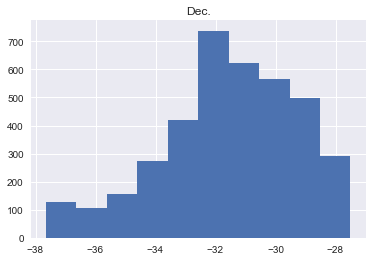

In [4]:
plt.hist(df['Dec.'])
plt.title('Dec.')
plt.show()

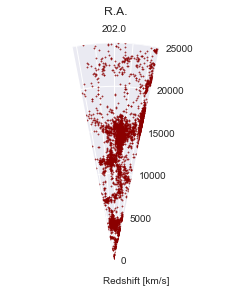

In [5]:
conv = (np.pi/180.)
r = df['V']
RA = df['R.A.']*conv
DEC   = df['Dec.']*conv
dRA = RA.max()-RA.min()
dDEC = DEC.max()-DEC.min()
color= 'darkred'
fig = plt.figure()
ax = fig.add_subplot(111,polar=True)
C = ax.scatter(RA,r,c=color,s=2,cmap='hsv',alpha=0.75)
ax.set_thetamin(RA.min()/conv)
ax.set_thetamax(RA.max()/conv)
ax.set_theta_offset(245*conv)
ax.set_rmax(25000)
ax.set_xticklabels(['','','',np.round(RA.mean()/conv),'',''])
ax.set_title('R.A.',y=1.1)
ax.text(0,3000,'Redshift [km/s]')
plt.show()


In [6]:
yRA = (RA-(RA.min()+dRA*0.5))*(np.pi/180.)
yDEC  = (DEC-(DEC.min()+dDEC*0.5))*(np.pi/180.)
rRA =r*np.sin(yRA)
rDEC=r*np.sin(yDEC)

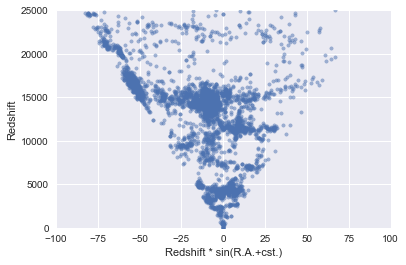

In [7]:
plt.scatter(rRA,r,marker='.',alpha=0.5)
plt.xlim(-100,100)
plt.ylim(0,25000)
plt.xlabel('Redshift * sin(R.A.+cst.)')
plt.ylabel('Redshift')
plt.show()

In [8]:
X = np.vstack((rRA,r))
X=X.T
Xs = StandardScaler().fit_transform(X)

#### Galaxy group clustering

We will explore the performance of a couple of clustering algortihms starting with the simple k-mean method.
k-mean, where k is the number of clusters, can be seen as a special case of Gaussian mixture model with equal covariance per component.

k-means starts with a random choice of cluster centers. For repeatability, one should set the value of random_state.

An alternative to k-means is k-median, where the median is used instead of the mean. It has the advantage to be more robust to outliers but is is also much slower.

As criterion to find the optimal number of clusters, we will use the silhouette method, which aims to explain the consistancy within cluster data. The silhouette value will range between -1 and 1 and a high value indicates that items are well matched within clusters and weakly matched to neighboring clusters. 

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

#### K-means

In [9]:
# Python 2.7
# Scikit-learn version 0.19
# k-means algorithm
from sklearn.cluster import KMeans
#help("sklearn.cluster.KMeans")

In [10]:
col_list = ['blue','silver','darkgoldenrod','darkgreen',
        'darkmagenta','red','darkorange','gold',
        'darkorchid','aqua','cadetblue',
        'darkolivegreen','burlywood','chartreuse',
        'chocolate','coral','cornflowerblue','black',
        'darkkhaki','pink','moccasin','limegreen']

from matplotlib import cm
# Use all colors that matplotlib provides by default.
color = cycle(colors.cnames.keys())
color_iter = cycle(col_list)

def plot_clustering(title):
    plt.subplots(figsize=(8, 5))
    plt.subplot(111)
    plt.scatter(rRA,r,alpha=0.5,marker=".")
    plt.title(title)
    for i in range(n_clusters_):
        color = cm.spectral(float(i) / n_clusters)
        plt.scatter(rRA[labels == i],r[labels == i],
                    alpha=0.5,marker=".",color=color)
        plt.xlabel('Redshift * sin(R.A.+cst.)')
        plt.ylabel('Redshift (km/s)')

Number of clusters: 5 Silhouette score: 0.669
Number of clusters: 6 Silhouette score: 0.668
Number of clusters: 7 Silhouette score: 0.678
Number of clusters: 8 Silhouette score: 0.714
Number of clusters: 9 Silhouette score: 0.695
Number of clusters: 10 Silhouette score: 0.662
Number of clusters: 11 Silhouette score: 0.657
Choosing n_clusters= 8


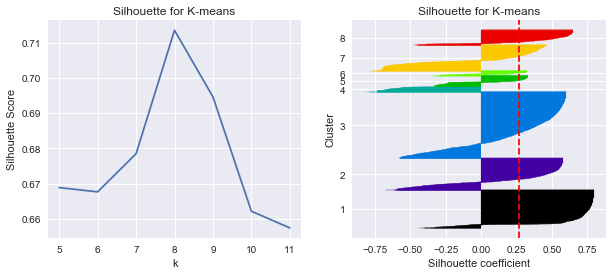

Silhouette Coefficient: 0.714


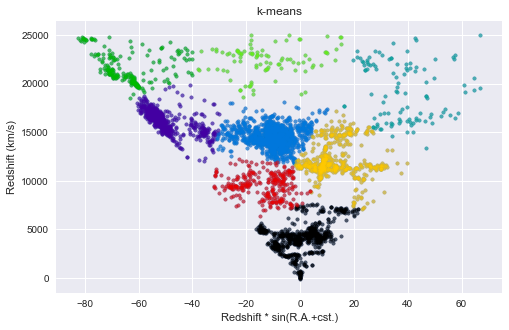

In [11]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

all_scores = []
clusters = np.arange(5,12,1)
for n_clusters in clusters:
    kmodel = KMeans(n_clusters=n_clusters,random_state=1)
    kmodel.fit(Xs)
    labels = kmodel.labels_
    centroids = kmodel.cluster_centers_
    score = silhouette_score(Xs, labels, metric='sqeuclidean')
    all_scores.append(score)
    print "Number of clusters:",n_clusters,"Silhouette score: %0.3f" % score
  # Set the size of the plot
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(clusters,all_scores)
plt.grid(True)
plt.ylabel("Silhouette Score")
plt.xlabel("k")
plt.title("Silhouette for K-means")

ibest = np.argmax(all_scores)
print "Choosing n_clusters=", clusters[ibest]
# Initialize the clusterer with n_clusters value and a random generator
model = KMeans(n_clusters=clusters[ibest], init='k-means++', 
               n_init=10, random_state=1)
model.fit_predict(Xs)
cluster_labels = np.unique(model.labels_)
n_clusters = cluster_labels.shape[0]

# Compute the silhouette scores for each sample
silhouette_vals = silhouette_samples(X, model.labels_)

plt.subplot(1, 2, 2)

y_lower, y_upper = 0,0
yticks = []
for i, c  in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[model.labels_ ==c]
    c_silhouette_vals.sort()
    y_upper += len(c_silhouette_vals)
    color = cm.spectral(float(i) / n_clusters)
    plt.barh(range(y_lower, y_upper), c_silhouette_vals, 
    facecolor=color,
    edgecolor=color, alpha=0.7)
    yticks.append((y_lower + y_upper) / 2)
    y_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)

plt.yticks(yticks, cluster_labels+1)
# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.title("Silhouette for K-means")
plt.show()

# we choose the number of clusters to be 8
n_clusters_ = clusters[ibest]
k_means = KMeans(n_clusters=n_clusters_,random_state=1)
k_means.fit(Xs)
labels = k_means.labels_
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(Xs, labels, metric='sqeuclidean'))
plot_clustering('k-means')

#### k-Medians

A simple alternative to k-Means is to use the median instead of the mean values.

Silhouette Coefficient: 0.479


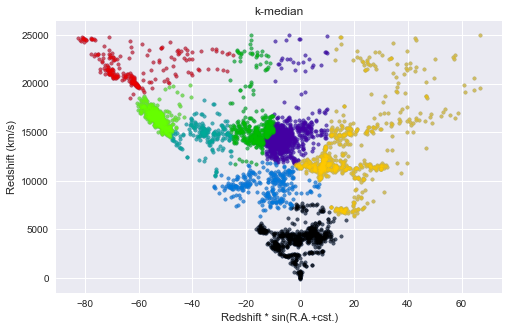

In [12]:
# require sklearn-extensions
# (sudo) pip install sklearn-extensions
from sklearn_extensions.fuzzy_kmeans import KMedians

n_clusters_ = clusters[ibest]
k_median = KMedians(k=n_clusters_,random_state=1)
k_median.fit(Xs)
labels = k_median.labels_
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(Xs, labels, metric='sqeuclidean'))
plot_clustering('k-median')

#### Expectation-Maximixation (EM) clustering using Gaussian Mixture Models (GMM)

K-means use a simple definition for the cluster centers. K-means performs well for clusters in the form of blobs. Using GMM means that we have that the data points are gaussian distrubuted. In 2D clusters can then take ellipses as shape. In high-dimension the shapes are still ellipsoids. In this method each gaussian is assigned a cluster. The parameters of the Gaussians are found by the expectation-maximization optimization method.
In contrast to other clustering methods, a data point can belong to more than one cluster, this is called a mixed membership.

In [13]:
from sklearn.mixture import GaussianMixture
#help("sklearn.mixture.GaussianMixture")

In [14]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
    #Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                        covariance_type=cv_type,tol=1e-3,max_iter=150,
                        n_init=1,random_state=2018)
        gmm.fit(Xs)
        bic.append(gmm.bic(Xs))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm # save the model with the lowest BIC
            nbest = n_components

bic = np.array(bic)
bars = []
print "Best model number of components:",nbest

Best model number of components: 13


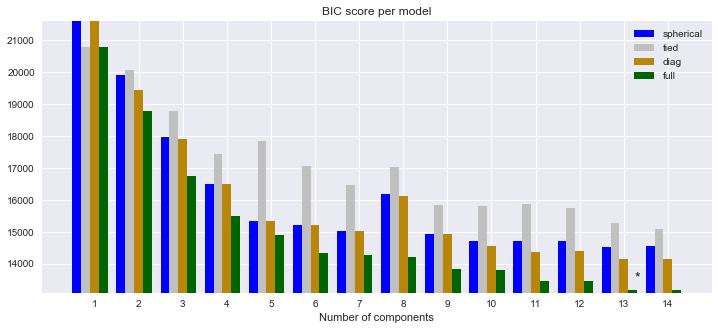

In [15]:
# Plot the BIC scores
plt.subplots(figsize=(12, 5))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
    (i + 1) * len(n_components_range)],
    width=.2, color=color))

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
.2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)
plt.show()

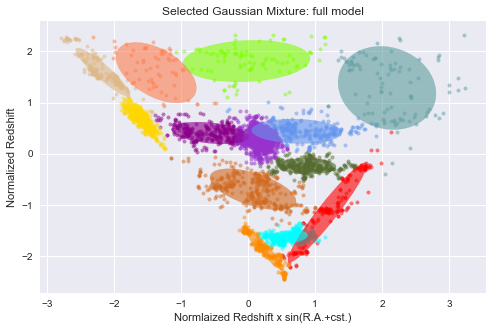

In [16]:
# Plot the best solution
splot= plt.subplots(figsize=(8, 5))
splot = plt.subplot(111)
Y_ = best_gmm.predict(Xs)

def plot_gmm():
    for i, (mean, cov, color) in enumerate(zip(best_gmm.means_,
                                               best_gmm.covariances_,
                                                color_iter)):
        v, w = np.linalg.eigh(cov)
        if not np.any(Y_ == i):
            continue
        plt.scatter(Xs[Y_ == i, 0], Xs[Y_ == i, 1], 
                    alpha=0.5, color=color,marker=".")
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, 
                                  v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.6)
        splot.add_artist(ell)
    
    plt.xlabel('Normlaized Redshift x sin(R.A.+cst.)')
    plt.ylabel('Normalized Redshift')
    plt.title('Selected Gaussian Mixture: full model')
    plt.show()
plot_gmm()

In [17]:
# DBSCAN algorithm
from sklearn.cluster import DBSCAN
#help("sklearn.cluster.DBSCAN")
# DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
#  Finds core samples of high density and expands clusters from them.
#  Good for data which contains clusters of similar density.  

In [18]:
db = DBSCAN(eps=0.1,min_samples=10).fit(Xs)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(Xs, labels, metric='sqeuclidean'))

Estimated number of clusters: 11
Silhouette Coefficient: 0.190


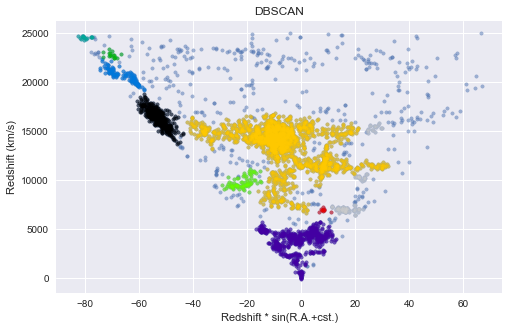

In [19]:
plot_clustering("DBSCAN")

DBSCAN algorithm is based on density. Therefore it tends to find clusters where there is gathering of galaxies. Galaxies in low density regions belong to any cluster. The algorithm can identify outliers unlike the mean-shift method and esclude them from the clusters. As such DBSCAN can be used to find outliers. It can find arbitrary sized and shaped clusters.

The main limitation is that DBSCAN is not performing well when clusters of different sizes are present because of the usage of a threshold distance and minmum points for identifying neighbors will then vary for cluster to cluster.

In our example, DBSCAN has excluded high redshift galaxies as cluster members because of the distances that separate each of them from the others.

#### Agglomerative hierarchical clustering

Agglomerative hierarchical clustering is based on a Tree algorithm. This algorithm is called in astronomy the friends-of-friends algorihtm.

In [20]:
from sklearn.cluster import AgglomerativeClustering
#help("sklearn.cluster.AgglomerativeClustering")

Silhouette Coefficient: 0.613


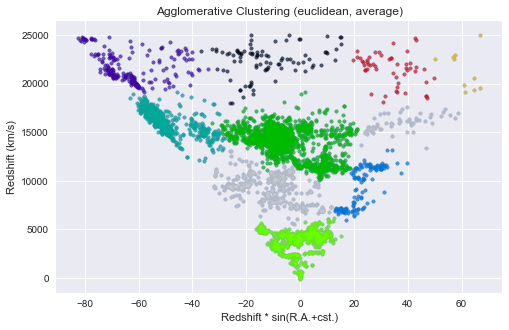

In [21]:
# Recursively merges the pair of clusters that minimally increases
# a given linkage distance.
# linkage : {"ward", "complete", "average"}, optional, default: "ward"
# affinity : string or callable, default: "euclidean"
#            Metric used to compute the linkage. 
#            Can be "euclidean", "l1", "l2","manhattan", "cosine", or
#            'precomputed'.
#            If linkage is "ward", only "euclidean" is accepted.
n_clusters_ = 10
ACmodel = AgglomerativeClustering(n_clusters=n_clusters_,
                                  affinity='euclidean',linkage='average')
ACmodel.fit(Xs)
labels = ACmodel.labels_
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(Xs, labels, metric='sqeuclidean'))
plot_clustering("Agglomerative Clustering (euclidean, average)")

Silhouette Coefficient: 0.610


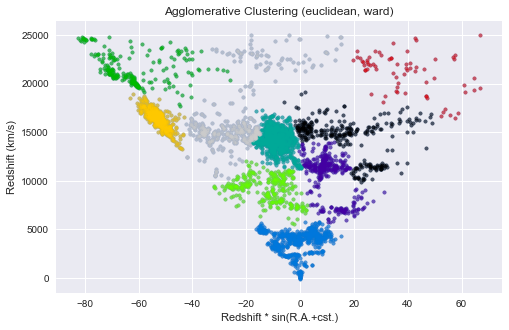

In [22]:
n_clusters_ = 10
ACmodel = AgglomerativeClustering(n_clusters=n_clusters_,
                                  affinity='euclidean',linkage='ward')
ACmodel.fit(Xs)
labels = ACmodel.labels_
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(Xs, labels, metric='sqeuclidean'))
plot_clustering("Agglomerative Clustering (euclidean, ward)")

Silhouette Coefficient: 0.601


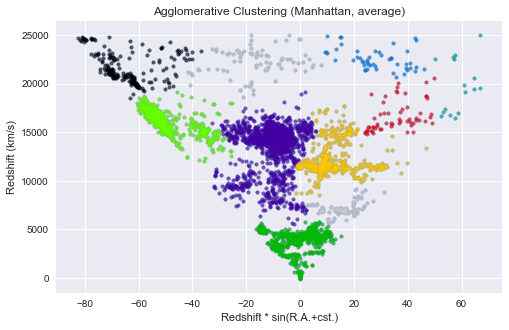

In [23]:
n_clusters_ = 10
ACmodel = AgglomerativeClustering(n_clusters=n_clusters_,
                                  affinity='manhattan',linkage='average')
ACmodel.fit(Xs)
labels = ACmodel.labels_
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(Xs, labels, metric='sqeuclidean'))
plot_clustering("Agglomerative Clustering (Manhattan, average)")

In [24]:
# mean-shift clustering algorithm
from sklearn.cluster import MeanShift, estimate_bandwidth
#help("sklearn.cluster.MeanShift")
#help("sklearn.cluster.estimate_bandwidth")

number of estimated clusters : 9
Silhouette Coefficient: 0.399


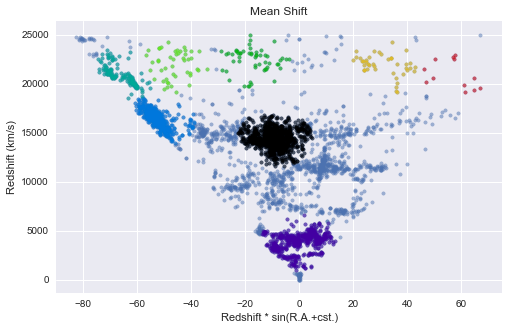

In [25]:
# Compute clustering with MeanShift
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(Xs, quantile=0.1, n_samples=200)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True,
               cluster_all=False)
ms.fit(Xs)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(Xs, labels, metric='sqeuclidean'))
plot_clustering("Mean Shift")

An advantage fo the Mean shift clustering algorithm is that it does not require an intial guess of the number of clusters.

In [26]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
#help("sklearn.cluster.AffinityPropagation")

Estimated number of clusters: 7
Silhouette Coefficient: 0.561


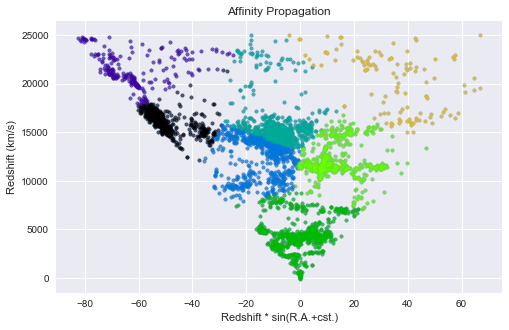

In [27]:
# Compute Affinity Propagation
# very slow
APmodel = AffinityPropagation(damping=0.9,preference=-200)
APmodel.fit(Xs)
labels = APmodel.labels_
cluster_centers_indices = APmodel.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(Xs, labels, metric='sqeuclidean'))
plot_clustering("Affinity Propagation")

Silhouette Coefficient: 0.501


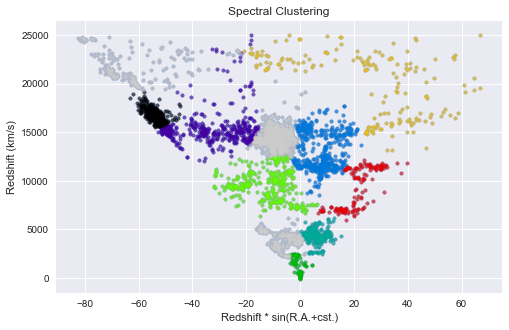

In [28]:
from sklearn.cluster import SpectralClustering
n_clusters_ = 11
spectral = SpectralClustering(
    n_clusters=n_clusters_, eigen_solver='arpack',
    affinity="nearest_neighbors")
spectral.fit(Xs)
labels = spectral.labels_
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(Xs, labels, metric='sqeuclidean'))
plot_clustering("Spectral Clustering")

Silhouette Coefficient: 0.663


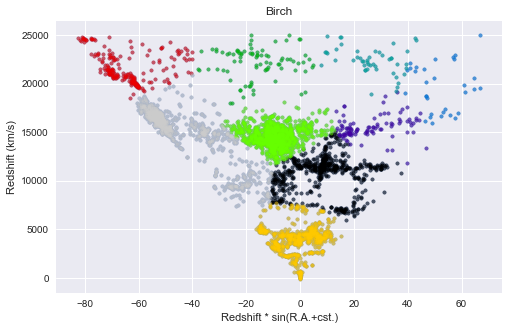

In [57]:
# Birch
from sklearn.cluster import Birch
birch = Birch(n_clusters=10)
n_clusters_ = 10
birch.fit(Xs)
labels = birch.labels_
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(Xs, labels, metric='sqeuclidean'))
plot_clustering("Birch")

Galaxies separated by voids are still classified as members of a same clusters by this algorithm.

#### minimum Spanning Tree

We use the minimum spannng tree algorithm to find hierarchy in the galaxy distribution.

In [30]:
# Minimum Spanning Tree
from scipy.interpolate import interp1d
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.neighbors import kneighbors_graph
#------------------------------------------------------------
# generate a sparse graph using the k nearest neighbors of each point
# here the hyper-parameter is set to 10
G = kneighbors_graph(Xs, n_neighbors=10, mode='distance')
#------------------------------------------------------------
# Compute the minimum spanning tree of this graph
T = minimum_spanning_tree(G, overwrite=True)
#------------------------------------------------------------
# Get the x, y coordinates of the beginning and end of each line segment
T = T.tocoo()
dist = T.data
p1 = T.row
p2 = T.col
A = Xs[p1].T
B = Xs[p2].T
x_coords = np.vstack([A[0], B[0]])
y_coords = np.vstack([A[1], B[1]])

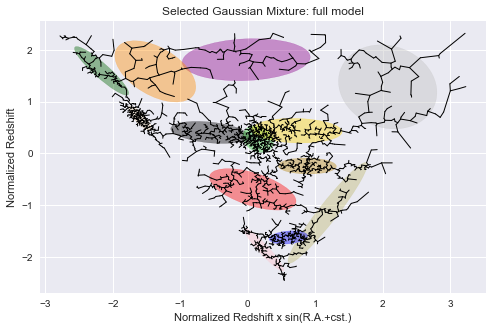

In [31]:
# From the Gaussian Mixture Analysis
splot= plt.subplots(figsize=(8, 5))
splot= plt.subplot(111)
plt.plot(x_coords, y_coords, c='k', lw=1)

Y_ = best_gmm.predict(Xs)
for i, (mean, cov, color) in enumerate(zip(best_gmm.means_, 
                                           best_gmm.covariances_,
color_iter)):
    v, w = np.linalg.eigh(cov)
    if not np.any(Y_ == i):
           continue
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1],
                              180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.4)
    splot.add_artist(ell)
    
plt.xlabel('Normalized Redshift x sin(R.A.+cst.)')
plt.ylabel('Normalized Redshift')
plt.title('Selected Gaussian Mixture: full model')
plt.show()

In this notebook, we have explored different clustering algorithm on a real (adapted) astronomical dataset.

The cluster membership depends on the algorithm and its hyper-parameters.

### Discussion on the results:
- the best performing method for this dataset seems to be the simplest one: the k-mean algorithm. However, one has to play with the number of requested clusters.
- k-medians' performance is much lower than k-means
- the Agglomerative Clustering method gives similar results.
- the Gaussian Mixture model also derives reasonnable results.
- the Birch algorithm finds clusters that have voids.
- DBSCAN excludes some galaxies from cluster membership. Is that physicaly meaningful? Yes density has a physical meaning and objects in low density regions should not be part of any cluster. The silhouette coefficient is in this case not a good criterion to determine the best hyper-parameters or to compare different clustering algorithms.
- the Mean Shift methods fails to provide valid results.
- the Affinity Propagation separated a cluster into 2.
- one can combine a clustering method with the minimum spanning tree representation of the data.

### Density estimation & wavelet decomposition

In this part of the notebook, we will perform now some density estimation for galaxies using
- gaussian density kernel (astroML.density_estimation.KDE)
- the k-nearest-neighbor estimator optimized for a small-scale structure(with k = 5: astroML.density_estimation.KNeighborsDensity
- one optimized for a large-scale structure (with k = 40). 

We will use modules in the astroML package.

In [32]:
from sklearn.neighbors import KDTree, KernelDensity
from matplotlib.colors import LogNorm

In [33]:
# input x,y are the locations of the points, here the galaxies
# return a density map at grid locations xx,yy
def kde2D(x,y,bandwidth=0.1,xbins=100j,ybins=100j,**kwargs):
    # create grid of sample locatios (default: 100x100)
    xx,yy = np.mgrid[x.min():x.max():xbins,
                    y.min():y.max():ybins]
    
    xy_sample = np.vstack([yy.ravel(),xx.ravel()]).T
    xy_train = np.vstack([y,x]).T
    kde_skl = KernelDensity(bandwidth=bandwidth,**kwargs)
    kde_skl.fit(xy_train)
    # score_Samples() returns the log_likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx,yy,np.reshape(z,xx.shape)

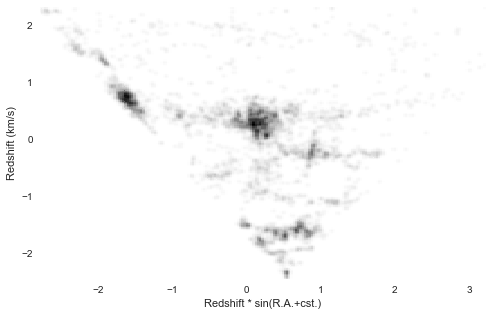

In [34]:
xtitle='Redshift * sin(R.A.+cst.)'
ytitle='Redshift (km/s)'

#help("matplotlib.pyplot.pcolormesh")
xx,yy,zz = kde2D(Xs[:,0],Xs[:,1],bandwidth=0.025,xbins=200j,ybins=200j)
plt.figure(figsize=(8, 5))
plt.pcolormesh(xx,yy,zz,cmap=plt.cm.binary)
plt.xlabel(xtitle)
plt.ylabel(ytitle)
plt.show()

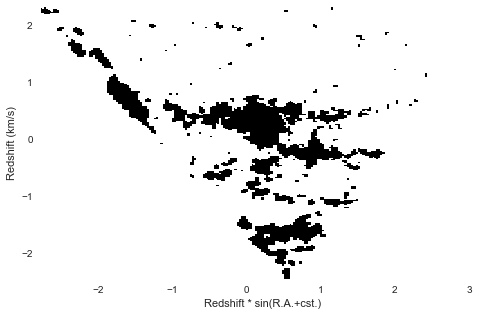

In [35]:
threshold = 0.1
zzb = np.copy(zz)
zzb[zz > threshold]=1.
zzb[zz <= threshold]=0.
splot= plt.subplots(figsize=(8, 5))
splot = plt.subplot(111)
plt.xlabel(xtitle)
plt.ylabel(ytitle)
plt.pcolormesh(xx,yy,zzb,cmap=plt.cm.binary)
plt.show()

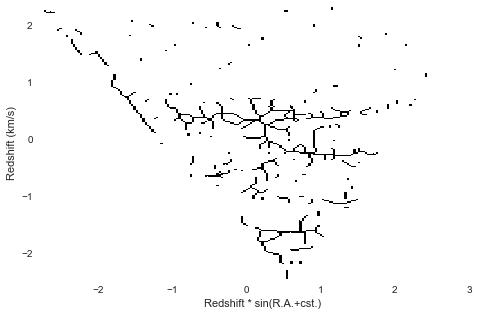

In [36]:
from skimage.morphology import skeletonize
from skimage.util import invert
#skeleton=invert(np.rot90(skeletonize(zzb)))
skeleton=skeletonize(zzb)
plt.figure(figsize=(8, 5))
plt.xlabel(xtitle)
plt.ylabel(ytitle)
#plt.imshow(skeleton)
zzs = skeleton.astype(float)
plt.pcolormesh(xx,yy,zz,cmap=plt.cm.binary)
plt.pcolormesh(xx,yy,zzs,cmap=plt.cm.binary)
plt.show()


In [37]:
# load an extra routine from the astroML package
from astroML.density_estimation import KNeighborsDensity
#help("astroML.density_estimation.KNeighborsDensity")

In [38]:
def knd2D(x,y,method='bayesian',nneighbours=5,xbins=100j,ybins=100j):
    # create grid of sample locatios (default: 100x100)
    xx,yy = np.mgrid[x.min():x.max():xbins,
                    y.min():y.max():ybins]
    xy_sample = np.vstack([yy.ravel(),xx.ravel()]).T
    xy_train = np.vstack([y,x]).T
    knn = KNeighborsDensity(method,nneighbours)
    z = knn.fit(xy_train).eval(xy_sample)
    return xx,yy,np.reshape(z,xx.shape)

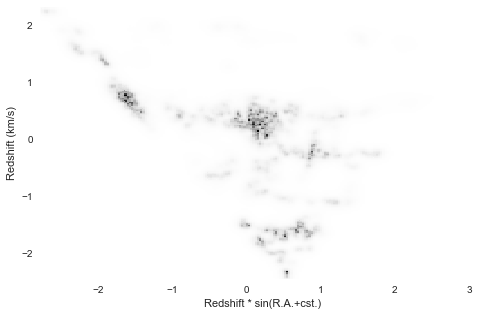

In [39]:
xx,yy,zz10 = knd2D(Xs[:,0],Xs[:,1],nneighbours=10,xbins=200j,ybins=200j)
plt.figure(figsize=(8, 5))
plt.pcolormesh(xx,yy,zz10,cmap=plt.cm.binary)
plt.xlabel(xtitle)
plt.ylabel(ytitle)
plt.show()

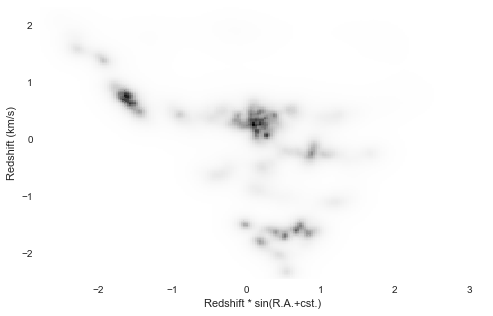

In [40]:
xx,yy,zz40 = knd2D(Xs[:,0],Xs[:,1],nneighbours=40,xbins=200j,ybins=200j)
plt.figure(figsize=(8, 5))
plt.pcolormesh(xx,yy,zz40,cmap=plt.cm.binary)
plt.xlabel(xtitle)
plt.ylabel(ytitle)
plt.show()

In [41]:
def wavefilter(data, maxlevel = 6):
    """
    This function requires that the NumPy and PyWavelet packages
    are installed. They are freely available at:
    
    NumPy - http://numpy.scipy.org/
    PyWavelets - http://www.pybytes.com/pywavelets/#download
    
    Filter a multi-channel signal using wavelet filtering.
    
    data     - n x m array, n=number of channels in the signal, 
                m=number of samples in the signal
    maxlevel - the level of decomposition to perform on the data. 
                This integer implicitly defines the cutoff frequency 
                of the filter.
                Specifically, cutoff frequency = 
                            samplingrate/(2^(maxlevel+1))
    """
    
    import pywt
    
    # We will use the Daubechies(4) wavelet
    wname = "db4"
    # Haar
    #wname = "haar"
    
    data = np.atleast_2d(data)
    numwires, datalength = data.shape
    
    # Initialize the container for the filtered data
    fdata = np.empty((numwires, datalength))
    
    for i in range(numwires):
        # Decompose the signal (discrete wavelet transform)
        c = pywt.wavedec(data[i,:], wname, level=maxlevel)
        # Destroy the approximation or scalling coefficients
        # are low-pass representation of the signal and the details are
        # the wavelet coefficients
        c[0][:] = 0
        # Reconstruct the signal and save it
        fdata[i,:] = pywt.waverec(c, wname)
    if fdata.shape[0] == 1:
        return fdata.ravel() # If the signal is 1D, return a 1D array
    else:
        return fdata # Otherwise, give back the 2D array

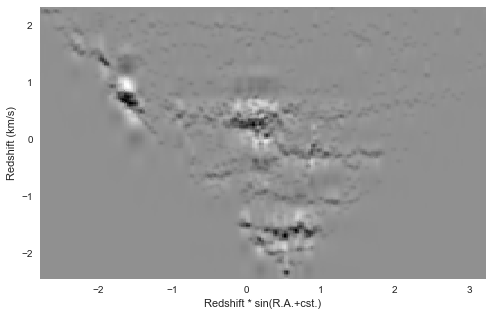

In [42]:
wave=wavefilter(zz, maxlevel = 4)
plt.figure(figsize=(8, 5))
plt.pcolormesh(xx,yy,wave,cmap=plt.cm.binary)
plt.xlabel(xtitle)
plt.ylabel(ytitle)
plt.show()

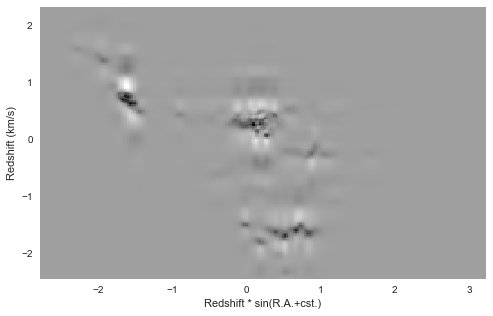

In [43]:
wave=wavefilter(zz40, maxlevel = 4)
plt.figure(figsize=(8, 5))
plt.pcolormesh(xx,yy,wave,cmap=plt.cm.binary)
plt.xlabel(xtitle)
plt.ylabel(ytitle)
plt.show()

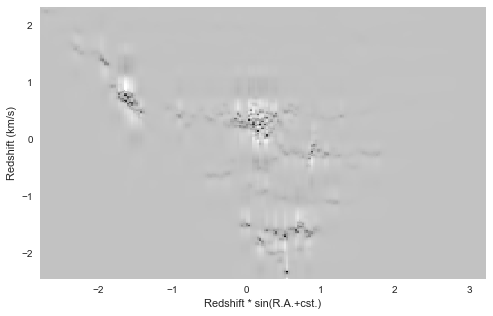

In [44]:
wave=wavefilter(zz10, maxlevel = 4)
plt.figure(figsize=(8, 5))
plt.pcolormesh(xx,yy,wave,cmap=plt.cm.binary)
plt.xlabel(xtitle)
plt.ylabel(ytitle)
plt.show()

The wavelet analysis shows the regions of high galaxy densities.

### Velocity dispersion in dense and less dense regions

First we use the clustering routine DBSCAN to find the dense regions (in different clusters) and the more diffuse regions.

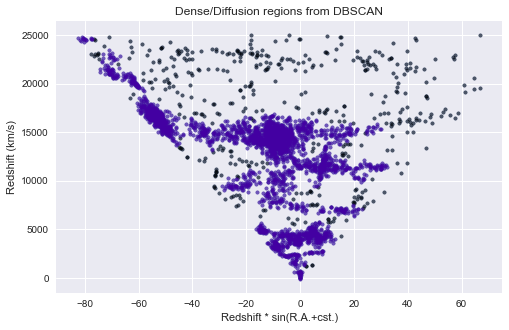

In [56]:
wdense = (db.labels_ > -1)
wdiffuse = (db.labels_ == 0)
labels1 = np.zeros(Xs.shape[0])
labels1[wdense] = 1
labels = labels1
plot_clustering("Dense/Diffusion regions from DBSCAN")

In [46]:
SigV = df['SigV']

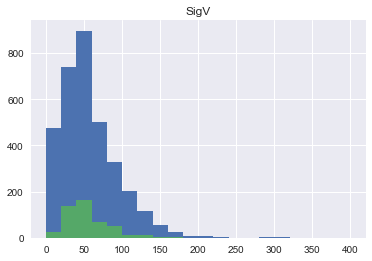

In [47]:
plt.hist(SigV[wdense],range=[0,400],bins=20)
plt.hist(SigV[wdiffuse],range=[0,400],bins=20)
plt.title("SigV")
plt.show()

In [48]:
import scipy.stats as stat
print "Dense region velocity dispersion"
print stat.describe(SigV[wdense])

Dense region velocity dispersion
DescribeResult(nobs=3372, minmax=(0, 899), mean=57.506227758007114, variance=2376.6089792990456, skewness=7.247038704881827, kurtosis=110.29483296874484)


In [49]:
print "Diffuse region velocity dispersion"
print stat.describe(SigV[wdiffuse])

Diffuse region velocity dispersion
DescribeResult(nobs=483, minmax=(0, 193), mean=55.577639751552795, variance=856.33161516455777, skewness=1.5750117191269177, kurtosis=3.2466652636814493)


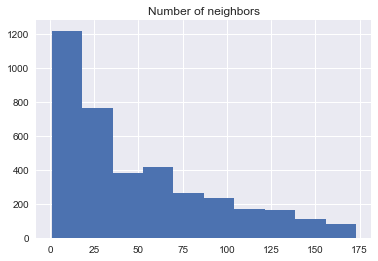

In [50]:
# First construct a KDTree
from sklearn.neighbors import KDTree
tree = KDTree(Xs)
# and find the number of neighbors for each galaxy within a certain radius
radius = 0.1
n_neighbors=tree.query_radius(Xs,radius, count_only = True, return_distance=False)
plt.hist(n_neighbors,bins=10)
plt.title("Number of neighbors")
SigV = df['SigV']
# the threshold for a galaxy to be in a dense environment
dense_thres = 5
wdense   = (n_neighbors  > dense_thres)
wdiffuse = (n_neighbors <= dense_thres)

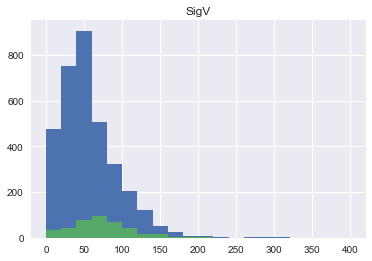

In [51]:
plt.hist(SigV[wdense],range=[0,400],bins=20)
plt.hist(SigV[wdiffuse],range=[0,400],bins=20)
plt.title("SigV")
plt.show()

In [52]:
print "Dense region velocity dispersion"
print stat.describe(SigV[wdense])

Dense region velocity dispersion
DescribeResult(nobs=3391, minmax=(0, 899), mean=57.330875847832495, variance=2354.0863590851714, skewness=7.299218400436881, kurtosis=111.82198954281472)


In [53]:
print "Diffuse region velocity dispersion"
print stat.describe(SigV[wdiffuse])

Diffuse region velocity dispersion
DescribeResult(nobs=411, minmax=(0, 899), mean=74.326034063260337, variance=3249.1178327695684, skewness=7.710480019938174, kurtosis=105.62189048501222)


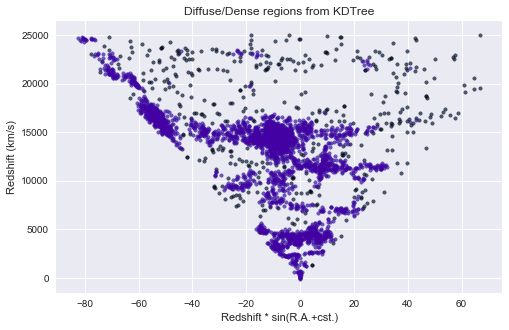

In [54]:
labels2 = np.zeros(Xs.shape[0])
labels2[wdense] = 1
labels = labels2
plot_clustering("Diffuse/Dense regions from KDTree")

In [55]:
from sklearn.metrics import cohen_kappa_score
print "agreement Cohen's kappa:",cohen_kappa_score(labels1,labels2)


agreement Cohen's kappa: 0.840916139186


The dense region velocity dispersions found by two methods are similar. Only the velocity dispersion in the diffuse regions seems to be sensitive on the members. The Cohen's kappa score measures the agreement between the two methods and we found a 84% agreement.
The fingers of God effect is recovered when using one method to determine the dense regions from the diffuse regions.

In astronomy the notion of density as criterion for clustering is important. As such an algorithm like DBSCAN may be more relevant than others. DBSCAN can in addition of assigning members to clusters leave out objects that are located in too low density regions to be in a cluster.